In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [5]:
imagePaths = list(paths.list_images('/content/drive/My Drive/face_detection_dataset'))
data = []
labels = []
for imagePath in imagePaths:
  label = imagePath.split(os.path.sep)[-2]
  image = load_img(imagePath, target_size=(224,224))
  image = img_to_array(image)
  image = preprocess_input(image)
  data.append(image)
  labels.append(label)

data = np.array(data, dtype='float32')
labels = np.array(labels)


In [6]:
baseModel = MobileNetV2(input_shape=(224,224,3), weights = 'imagenet', include_top=False)
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs = baseModel.input, outputs = headModel)
for layer in baseModel.layers:
  layer.trainable = False


9412608/9406464 [==============================] - 0s 0us/step


In [7]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [8]:
 #Initial Learning Rate
INIT_LR = 1e-4    
#Number of EPOCHS     
EPOCHS = 20
#Batch Size             
BS = 32                 
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
16/16 [==============================] - 25s 2s/step - loss: 0.1590 - accuracy: 0.9501 - val_loss: 0.0494 - val_accuracy: 0.9851
Epoch 2/20
16/16 [==============================] - 24s 1s/step - loss: 0.0996 - accuracy: 0.9800 - val_loss: 0.0430 - val_accuracy: 0.9851
Epoch 3/20
16/16 [==============================] - 24s 1s/step - loss: 0.0759 - accuracy: 0.9820 - val_loss: 0.0300 - val_accuracy: 0.9851
Epoch 4/20
16/16 [==============================] - 24s 1s/step - loss: 0.0622 - accuracy: 0.9860 - val_loss: 0.0221 - val_accuracy: 0.9925
Epoch 5/20
16/16 [==============================] - 24s 1s/step - loss: 0.0492 - accuracy: 0.9820 - val_loss: 0.0172 - val_accuracy: 0.9925
Epoch 6/20
16/16 [==============================] - 24s 1s/step - loss: 0.0447 - accuracy: 0.9840 - val_loss: 0.0138 - val_accuracy: 0.9925
Epoch 7/20
16/16 [==============================] - 24s 1s/step - loss: 0.0290 - accuracy: 0.9880 - val_loss: 

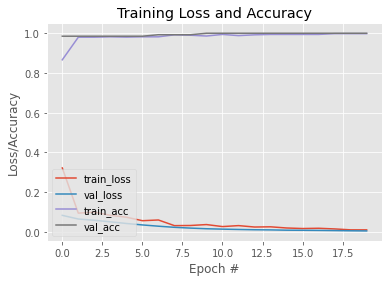

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
#To save the trained model
model.save('mask_recog.h5')

In [1]:
!git clone https://github.com/opencv/opencv.git
!mkdir Video

Cloning into 'opencv'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 279389 (delta 0), reused 0 (delta 0), pack-reused 279388
Receiving objects: 100% (279389/279389), 472.67 MiB | 15.83 MiB/s, done.
Resolving deltas: 100% (195207/195207), done.
Checking out files: 100% (6582/6582), done.


In [ ]:
#@title Java script code to access webcam
!pip install ffmpeg-python


from IPython.display import HTML, Javascript, display
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
import ffmpeg

video_file_test = '/content/Video/osy_test.mp4' 
  

VIDEO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var my_btn_txt = document.createTextNode("Press to start recording");
my_btn.appendChild(my_btn_txt);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);
var base64data = 0;
var reader;
var recorder, videoStream;
var recordButton = my_btn;
var handleSuccess = function(stream) {
  videoStream = stream;
  var options = {  
    mimeType : 'video/webm;codecs=vp9'  
  };            
  recorder = new MediaRecorder(stream, options);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('video');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);
    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
    }
  };
  recorder.start();
  };
recordButton.innerText = "Recording... press to stop";
navigator.mediaDevices.getUserMedia({video: true}).then(handleSuccess);
function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      videoStream.getVideoTracks()[0].stop();
      recordButton.innerText = "Saving the recording... Please wait!"
  }
}
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}
var data = new Promise(resolve=>{
recordButton.onclick = ()=>{
toggleRecording()
sleep(2000).then(() => {
  // wait 2000ms for the data to be available
  resolve(base64data.toString())
});
}
});
      
</script>
"""

def start_webcam():
  js = Javascript('''
    async function startWebcam() {
      const div = document.createElement('div');
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      
      return;
    }
    ''')
  
  display(js)
  data = eval_js('startWebcam()')
  
    
start_webcam()

def get_video():
  display(HTML(VIDEO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  return binary

In [ ]:
videofile = get_video()
with open(video_file_test, 'wb') as f:
  f.write(videofile)

In [5]:
import cv2
from google.colab.patches import cv2_imshow
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

cascPath = os.path.dirname(
    cv2.__file__) + "/data/haarcascade_frontalface_alt2.xml"

faceCascade = cv2.CascadeClassifier(cascPath)
model = load_model("mask_recog.h5")

video_capture = cv2.VideoCapture(video_file_test)
while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,
                                         scaleFactor=1.1,
                                         minNeighbors=5,
                                         minSize=(60, 60),
                                         flags=cv2.CASCADE_SCALE_IMAGE)
    faces_list=[]
    preds=[]
    for (x, y, w, h) in faces:
        face_frame = frame[y:y+h,x:x+w]
        face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
        face_frame = cv2.resize(face_frame, (224, 224))
        face_frame = img_to_array(face_frame)
        face_frame = np.expand_dims(face_frame, axis=0)
        face_frame =  preprocess_input(face_frame)
        faces_list.append(face_frame)
        if len(faces_list)>0:
            preds = model.predict(faces_list)
        for pred in preds:
            (mask, withoutMask) = pred
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        cv2.putText(frame, label, (x, y- 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)

        cv2.rectangle(frame, (x, y), (x + w, y + h),color, 2)
        # Display the resulting frame
    cv2_imshow(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
video_capture.release()
cv2.destroyAllWindows()

OSError: ignored